In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv').to_numpy()
np.random.shuffle(data)

data_dev = data[:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:] / 255.

data_train = data[1000:].T
Y_train = data_train[0]
X_train = data_train[1:] / 255.
_, m = X_train.shape

n_basis = 10
degree = 3
hidden_dim = 128
lr = 0.05
epochs = 50

In [31]:
class SplineLayer:
    def __init__(self, input_dim, n_basis, degree):
        self.input_dim = input_dim
        self.n_basis = n_basis
        self.degree = degree
        self.knots = np.linspace(0, 1, n_basis + degree + 1)
        self.S = np.random.randn(input_dim, n_basis) * 0.1

    def b_spline_basis(self, x, k, d):
        if d == 0:
            return ((x >= self.knots[k]) & (x < self.knots[k+1])).astype(float)
        denom1 = self.knots[k+d] - self.knots[k]
        denom2 = self.knots[k+d+1] - self.knots[k+1]
        term1 = 0
        if denom1 > 0:
            term1 = (x - self.knots[k]) / denom1 * self.b_spline_basis(x, k, d-1)
        term2 = 0
        if denom2 > 0:
            term2 = (self.knots[k+d+1] - x) / denom2 * self.b_spline_basis(x, k+1, d-1)
        return term1 + term2

    def compute_basis(self, X):  # X shape: (input_dim, m)
        d, m = X.shape
        B_all = np.zeros((d, self.n_basis, m))
        for i in range(d):
            for b in range(self.n_basis):
                B_all[i, b] = self.b_spline_basis(X[i], b, self.degree)
        return B_all

    def forward(self, X):
        self.last_input = X
        self.B_all = self.compute_basis(X)
        Phi = np.einsum('ib,ibm->im', self.S, self.B_all)
        return Phi

    def backward(self, grad_output):
        dS = np.einsum('im,ibm->ib', grad_output, self.B_all)
        return dS

In [32]:
class PhiSplineLayer:
    def __init__(self, hidden_dim, n_basis, degree):
        self.hidden_dim = hidden_dim
        self.n_basis = n_basis
        self.degree = degree
        self.knots = np.linspace(-5, 5, n_basis + degree + 1)
        self.S = np.random.randn(hidden_dim, n_basis) * 0.1

    def b_spline_basis(self, x, k, d):
        if d == 0:
            return ((x >= self.knots[k]) & (x < self.knots[k+1])).astype(float)
        denom1 = self.knots[k+d] - self.knots[k]
        denom2 = self.knots[k+d+1] - self.knots[k+1]
        term1 = 0
        if denom1 > 0:
            term1 = (x - self.knots[k]) / denom1 * self.b_spline_basis(x, k, d-1)
        term2 = 0
        if denom2 > 0:
            term2 = (self.knots[k+d+1] - x) / denom2 * self.b_spline_basis(x, k+1, d-1)
        return term1 + term2

    def compute_basis(self, Z):
        d, m = Z.shape
        B_all = np.zeros((d, self.n_basis, m))
        for i in range(d):
            for b in range(self.n_basis):
                B_all[i, b] = self.b_spline_basis(Z[i], b, self.degree)
        return B_all

    def forward(self, Z):
        self.last_input = Z
        self.B_all = self.compute_basis(Z)
        Phi = np.einsum('ib,ibm->im', self.S, self.B_all)
        return Phi

    def backward(self, grad_output):
        dS = np.einsum('im,ibm->ib', grad_output, self.B_all)
        return dS

In [33]:
def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def compute_loss(A2, Y):
    m = Y.shape[0]
    log_probs = -np.log(A2[Y, np.arange(m)] + 1e-8)
    return np.sum(log_probs) / m

def get_predictions(A):
    return np.argmax(A, axis=0)

def get_accuracy(preds, Y):
    return np.mean(preds == Y)

In [34]:
psi_layer = SplineLayer(784, n_basis, degree)
phi_layer = PhiSplineLayer(hidden_dim, n_basis, degree)
W = np.random.randn(hidden_dim, 784) * 0.1
b1 = np.zeros((hidden_dim, 1))
V = np.random.randn(10, hidden_dim) * 0.1
b2 = np.zeros((10, 1))


In [35]:
for i in range(epochs):
    Psi = psi_layer.forward(X_train)
    Z1 = W @ Psi + b1
    A1 = phi_layer.forward(Z1)
    Z2 = V @ A1 + b2
    A2 = softmax(Z2)
    
    # Backward
    one_hot_Y = one_hot(Y_train)
    dZ2 = A2 - one_hot_Y
    dV = (1/m) * dZ2 @ A1.T
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = V.T @ dZ2
    dS_phi = phi_layer.backward(dA1)
    dZ1 = np.einsum('ibm,ib->im', phi_layer.B_all, phi_layer.S)
    dW = (1/m) * dZ1 @ Psi.T
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    dPsi = W.T @ dZ1
    dS_psi = psi_layer.backward(dPsi)

    # Update
    V -= lr * dV
    b2 -= lr * db2
    W -= lr * dW
    b1 -= lr * db1
    psi_layer.S -= lr * dS_psi
    phi_layer.S -= lr * dS_phi

    if i % 5 == 0:
        preds = get_predictions(A2)
        acc = get_accuracy(preds, Y_train)
        loss = compute_loss(A2, Y_train)
        print(f"Epoch {i}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 0, Loss: 2.3070, Accuracy: 0.0997
Epoch 5, Loss: 2.3096, Accuracy: 0.0980
Epoch 10, Loss: 2.3073, Accuracy: 0.1002
Epoch 15, Loss: 2.3065, Accuracy: 0.0999
Epoch 20, Loss: 2.3062, Accuracy: 0.0999
Epoch 25, Loss: 2.3059, Accuracy: 0.1047
Epoch 30, Loss: 2.3057, Accuracy: 0.1045
Epoch 35, Loss: 2.3057, Accuracy: 0.1048
Epoch 40, Loss: 2.3055, Accuracy: 0.1051
Epoch 45, Loss: 2.3054, Accuracy: 0.1049


In [36]:
Psi_dev = psi_layer.forward(X_dev)
Z1_dev = W @ Psi_dev + b1
A1_dev = phi_layer.forward(Z1_dev)
Z2_dev = V @ A1_dev + b2
A2_dev = softmax(Z2_dev)
dev_preds = get_predictions(A2_dev)
dev_acc = get_accuracy(dev_preds, Y_dev)
print(f"Dev Accuracy: {dev_acc:.4f}")

Dev Accuracy: 0.1010


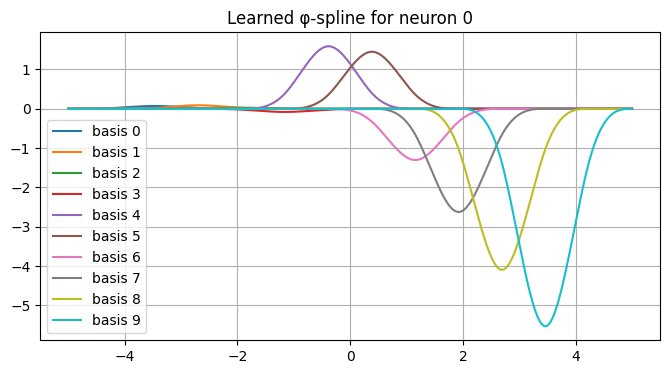

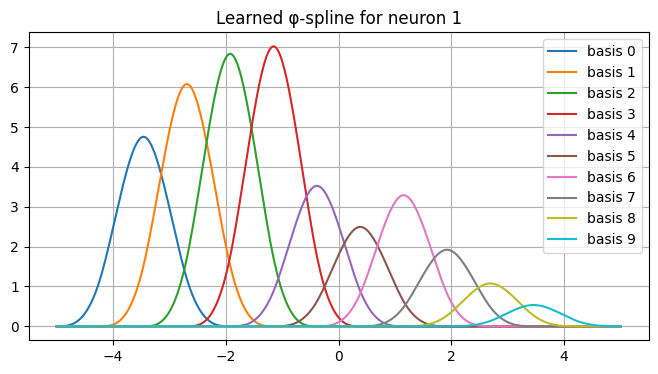

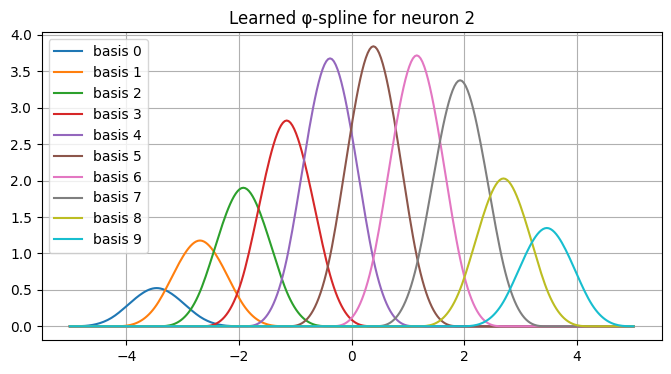

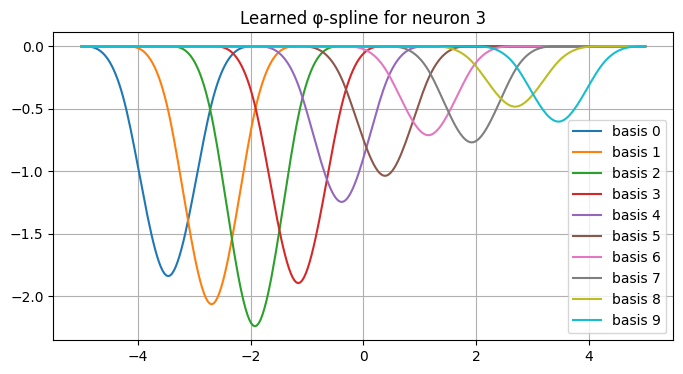

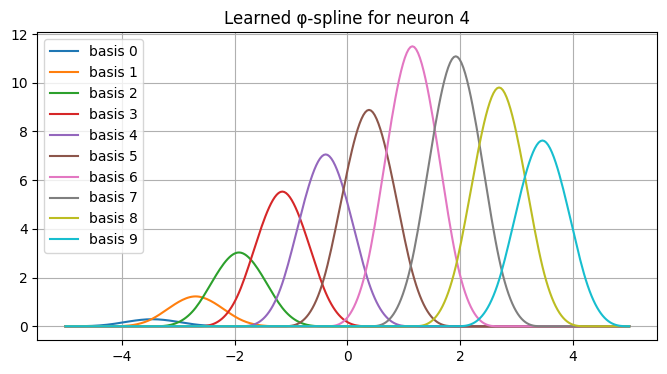

In [37]:
x_vis = np.linspace(-5, 5, 300)
for neuron in range(5):
    plt.figure(figsize=(8, 4))
    for b in range(n_basis):
        y = np.array([phi_layer.b_spline_basis(xi, b, degree) for xi in x_vis])
        plt.plot(x_vis, phi_layer.S[neuron, b] * y, label=f"basis {b}")
    plt.title(f"Learned φ-spline for neuron {neuron}")
    plt.grid()
    plt.legend()
    plt.show()